<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W3D3/tutorials/W3D3_NetworkCausality/W3D3_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy 2020: Week 3 Day 3, Tutorial 1

# Causality Day: Interventions

**Content creators**: Ari Benjamin, Tony Liu, Konrad Kording

**Content reviewers**: Mike X Cohen, Madineh Sarvestani, Ella Batty, Michael Waskom


---
#Tutorial Objectives

We list our overall day objectives below, with the sections we will focus on in this notebook in bold:

1.   **Master definitions of causality**
2.   **Understand that estimating causality is possible**
3.  **Learn 4 different methods and understand when they fail**
    1. **Perturbations**
    2. Correlations
    3. Simultaneous fitting/regression
    4. Instrumental variables

### Tutorial setting

How do we know if a relationship is causal? What does that mean? And how can we estimate causal relationships within neural data?

The methods we'll learn today are very general and can be applied to all sorts of data, and in many circumstances.
Causal questions are everywhere!


### Tutorial 1 Objectives:

1.   Simulate a neural system
2.   Understand perturbation as a method of estimating causality

---
# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable      

In [2]:
#@title Figure settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [3]:
#@title Helper functions


def sigmoid(x):
    """
    Compute sigmoid nonlinearity element-wise on x.
    
    Args:
        x (np.ndarray): the numpy data array we want to transform
    Returns
        (np.ndarray): x with sigmoid nonlinearity applied
    """
    return 1 / (1 + np.exp(-x))


def create_connectivity(n_neurons, random_state=42):
    """
    Generate our nxn causal connectivity matrix.

    Args:
        n_neurons (int): the number of neurons in our system.
        random_state (int): random seed for reproducibility

    Returns:
        A (np.ndarray): our 0.1 sparse connectivity matrix
    """
    np.random.seed(random_state)
    A_0 = np.random.choice([0, 1], size=(n_neurons, n_neurons), p=[0.9, 0.1])

    # set the timescale of the dynamical system to about 100 steps
    _, s_vals, _ = np.linalg.svd(A_0)
    A = A_0 / (1.01 * s_vals[0])

    # _, s_val_test, _ = np.linalg.svd(A)
    # assert s_val_test[0] < 1, "largest singular value >= 1"

    return A


def see_neurons(A, ax):
    """
    Visualizes the connectivity matrix.

    Args:
        A (np.ndarray): the connectivity matrix of shape (n_neurons, n_neurons)
        ax (plt.axis): the matplotlib axis to display on

    Returns:
        Nothing, but visualizes A.
    """
    A = A.T  # make up for opposite connectivity
    n = len(A)
    ax.set_aspect('equal')
    thetas = np.linspace(0, np.pi * 2, n, endpoint=False)
    x, y = np.cos(thetas), np.sin(thetas),
    ax.scatter(x, y, c='k', s=150)

    # Renormalize
    A = A / A.max()
    for i in range(n):
        for j in range(n):
            if A[i, j] > 0:
                ax.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i], color='k', alpha=A[i,j],
                         head_width=.15, width = A[i, j] / 25, shape='right',
                         length_includes_head=True)
    ax.axis('off')


def get_perturbed_connectivity_all_neurons(perturbed_X):
    """
    Estimates the connectivity matrix of perturbations through stacked correlations.

    Args:
        perturbed_X (np.ndarray): the simulated dynamical system X of shape
                                  (n_neurons, timesteps)

    Returns:
        R (np.ndarray): the estimated connectivity matrix of shape
                        (n_neurons, n_neurons)
    """
    # select perturbations (P) and outcomes (Outs)
    # we perturb the system every over time step, hence the 2 in slice notation
    P = perturbed_X[:, ::2]
    Outs = perturbed_X[:, 1::2]

    # stack perturbations and outcomes into a 2n by (timesteps / 2) matrix
    S = np.concatenate([P, Outs], axis=0)

    # select the perturbation -> outcome block of correlation matrix (upper right)
    R = np.corrcoef(S)[:n_neurons, n_neurons:]

    return R


def simulate_neurons_perturb(A, timesteps):
    """
    Simulates a dynamical system for the specified number of neurons and timesteps,
    BUT every other timestep the activity is clamped to a random pattern of 1s and 0s

    Args:
        A (np.array): the true connectivity matrix
        timesteps (int): the number of timesteps to simulate our system.

    Returns:
        The results of the simulated system.
        - X has shape (n_neurons, timeteps)
    """
    n_neurons = len(A)
    X = np.zeros((n_neurons, timesteps))

    for t in range(timesteps - 1):

        if t % 2 == 0:
            X[:, t] = np.random.choice([0, 1], size=n_neurons)

        epsilon = np.random.multivariate_normal(np.zeros(n_neurons), np.eye(n_neurons))
        X[:, t + 1] = sigmoid(A.dot(X[:, t]) + epsilon)  # we are using helper function sigmoid

    return X


def plot_connectivity_matrix(A, ax=None):
  """Plot the (weighted) connectivity matrix A as a heatmap
  
    Args:
      A (ndarray): connectivity matrix (n_neurons by n_neurons)
      ax: axis on which to display connectivity matrix
  """
  if ax is None:
    ax = plt.gca()
  lim = np.abs(A).max()
  im = ax.imshow(A, vmin=-lim, vmax=lim, cmap="coolwarm")
  ax.tick_params(labelsize=10)
  ax.xaxis.label.set_size(15)
  ax.yaxis.label.set_size(15)
  cbar = ax.figure.colorbar(im, ax=ax, ticks=[0], shrink=.7)
  cbar.ax.set_ylabel("Connectivity Strength", rotation=90, 
                     labelpad= 20,va="bottom")
  ax.set(xlabel="Connectivity from", ylabel="Connectivity to")


def plot_connectivity_graph_matrix(A):
  """Plot both connectivity graph and matrix side by side
  
    Args: 
      A (ndarray): connectivity matrix (n_neurons by n_neurons)
  
  """
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  see_neurons(A,axs[0])  # we are invoking a helper function that visualizes the connectivity matrix
  plot_connectivity_matrix(A)

  fig.suptitle("Neuron Connectivity")
  plt.show()

def plot_neural_activity(X):
  """Plot first 10 timesteps of neural activity

  Args:
    X (ndarray): neural activity (n_neurons by timesteps)

  """
  f, ax = plt.subplots()
  im = ax.imshow(X[:, :10])
  divider = make_axes_locatable(ax)
  cax1 = divider.append_axes("right", size="5%", pad=0.15)
  plt.colorbar(im, cax=cax1)
  ax.set(xlabel='Timestep', ylabel='Neuron', title='Simulated Neural Activity')


def plot_true_vs_estimated_connectivity(estimated_connectivity, true_connectivity, selected_neuron=None):
  """Visualize true vs estimated connectivity matrices

  Args:
    estimated_connectivity (ndarray): estimated connectivity (n_neurons by n_neurons)
    true_connectivity (ndarray): ground-truth connectivity (n_neurons by n_neurons)
    selected_neuron (int or None): None if plotting all connectivity, otherwise connectivity
      from selected_neuron will be shown

  """
  
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  
  if selected_neuron is not None:
    plot_connectivity_matrix(np.expand_dims(estimated_connectivity, axis=1), ax=axs[0])
    plot_connectivity_matrix(true_connectivity[:, [selected_neuron]], ax=axs[1])
    axs[0].set_xticks([0])
    axs[1].set_xticks([0])
    axs[0].set_xticklabels([selected_neuron])
    axs[1].set_xticklabels([selected_neuron])
  else:
    plot_connectivity_matrix(estimated_connectivity, ax=axs[0])
    plot_connectivity_matrix(true_connectivity, ax=axs[1])
  
  axs[1].set(title="True connectivity")
  axs[0].set(title="Estimated connectivity")

---
# Section 1: Defining and estimating causality


Video available at https://youtu.be/yiddT2sMbZM


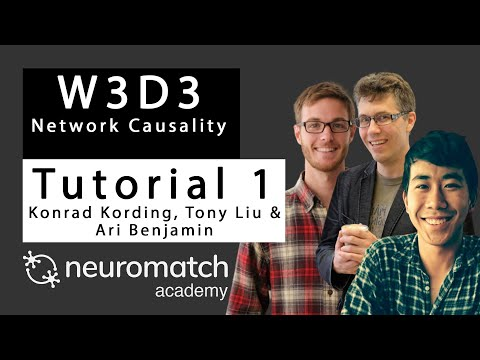

In [4]:
#@title Video 1: Defining causality
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="yiddT2sMbZM", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


Let's think carefully about the statement "**A causes B**". To be concrete, let's take two neurons. What does it mean to say that neuron $A$ causes neuron $B$ to fire?

The *interventional* definition of causality says that:
$$
(A \text{ causes } B) \Leftrightarrow ( \text{ If we force }A \text { to be different, then }B\text{ changes})
$$

To determine if $A$ causes $B$ to fire, we can inject current into neuron $A$ and see what happens to $B$.

**A mathematical definition of causality**: 
Over many trials, the average causal effect $\delta_{A\to B}$ of neuron $A$ upon neuron $B$ is the average change in neuron $B$'s activity when we set $A=1$ versus when we set $A=0$.


$$
\delta_{A\to B} = \mathbb{E}[B | A=1] -  \mathbb{E}[B | A=0] 
$$

Note that this is an average effect. While one can get more sophisticated about conditional effects ($A$ only effects $B$ when it's not refractory, perhaps), we will only consider average effects today.

**Relation to a randomized controlled trial (RCT)**:
The logic we just described is the logic of a randomized control trial (RCT). If you randomly give 100 people a drug and 100 people a placebo, the effect is the difference in outcomes.



## Exercise 1: Randomized controlled trial for two neurons

Let's pretend we can perform a randomized controlled trial for two neurons. Our model will have neuron $A$ synapsing on Neuron $B$:
$$B = A + \epsilon$$
 where $A$ and $B$ represent the activities of the two neurons and $\epsilon$ is standard normal noise $\epsilon\sim\mathcal{N}(0,1)$.

Our goal is to perturb $A$ and confirm that $B$ changes. 


In [5]:
def neuron_B(activity_of_A):
  """Model activity of neuron B as neuron A activity + noise

  Args:
    activity_of_A (ndarray): An array of shape (T,) containing the neural activity of neuron A
  
  Returns:
    ndarray: activity of neuron B
  """
  noise = np.random.randn(activity_of_A.shape[0])
  return activity_of_A + noise

np.random.seed(12)

# Neuron A activity of zeros
A_0 = np.zeros(5000)

# Neuron A activity of ones
A_1 = np.ones(5000)

###########################################################################
## TODO for students: Estimate the causal effect of A upon B 
## Use eq above (difference in mean of B when A=0 vs. A=1)
###########################################################################
diff_in_means = ...
#print(diff_in_means)

In [6]:
# to_remove solution
def neuron_B(activity_of_A):
  """Model activity of neuron B as neuron A activity + noise

  Args:
    activity_of_A (ndarray): An array of shape (T,) containing the neural activity of neuron A

  Returns:
    ndarray: activity of neuron B
  """
  noise = np.random.randn(activity_of_A.shape[0])
  return activity_of_A + noise

np.random.seed(12)

# Neuron A activity of zeros
A_0 = np.zeros(5000)

# Neuron A activity of ones
A_1 = np.ones(5000)

diff_in_means = neuron_B(A_1).mean() - neuron_B(A_0).mean()
print(diff_in_means)

0.9907195190159408


You should get a difference in means of `0.990719` (so very close to one). 

---
# Section 2: Simulating a system of neurons



Can we still estimate causal effects when the neurons are in big networks? This is the main question we will ask today. Let's first create our system, and the rest of today will be spend analyzing it.


Video available at https://youtu.be/oPJz49dAuL8


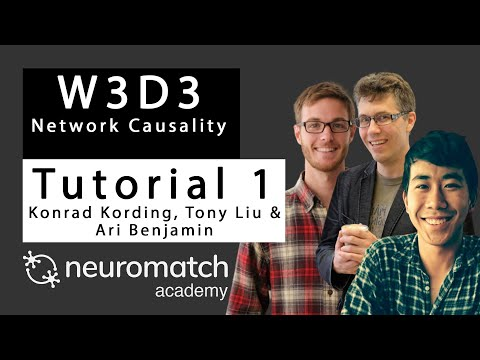

In [7]:
#@title Video 2: Simulated neural system model
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="oPJz49dAuL8", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

**Video correction**: the connectivity graph plots and associated explanations in this and other videos show the wrong direction of connectivity (the arrows should be pointing the opposite direction). This has been fixed in the figures below.

## Section 2.1: Our system

This section recaps the system described in Video 2 so may be skipped. 

Our system has N interconnected neurons that affect each other over time. Each neuron at time $t+1$ is a function of the activity of the other neurons from the previous time $t$. 

Neurons affect each other nonlinearly: each neuron's activity at time $t+1$ consists of a linearly weighted sum of all neural activities at time $t$, with added noise, passed through a nonlinearity:

$$
\vec{x}_{t+1} = \sigma(A\vec{x}_t + \epsilon_t), 
$$

- $\vec{x}_t$ is an $n$-dimensional vector representing our $n$-neuron system at timestep $t$
- $\sigma$ is a sigmoid nonlinearity
- $A$ is our $n \times n$ *causal ground truth connectivity matrix* (more on this later)
- $\epsilon_t$ is random noise: $\epsilon_t \sim N(\vec{0}, I_n)$
- $\vec{x}_0$ is initialized to $\vec{0}$

$A$ is a connectivity matrix, so the element $A_{ij}$ represents the causal effect of neuron $i$ on neuron $j$. In our system, neurons will receive connections from only 10% of the whole population on average.


## Section 2.2: Visualize  true connectivity

We will create a connectivity matrix between 6 neurons and visualize it in two different ways: as a graph with directional edges between connected neurons and as an image of the connectivity matrix.

*Check your understanding*: do you understand how the left plot relates to the right plot below?

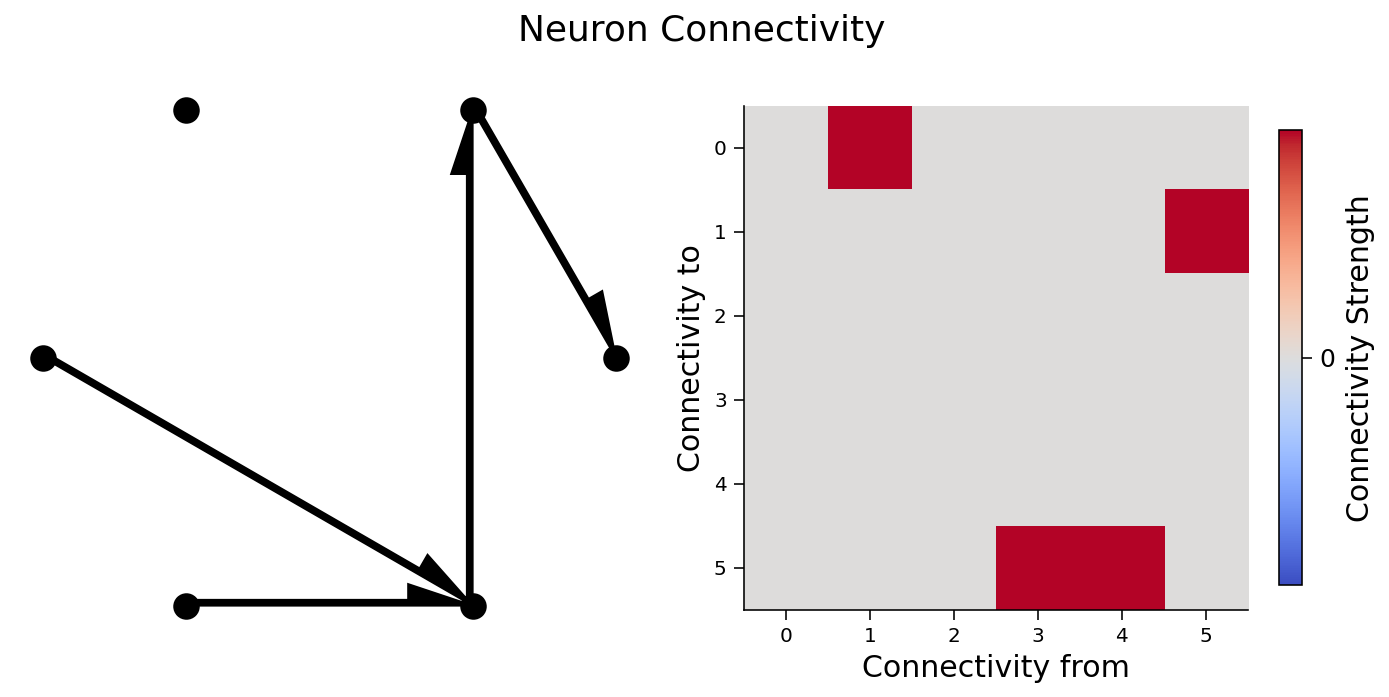

In [8]:
#@markdown Execute this cell to visualize connectivity

## Initializes the system
n_neurons = 6  
A = create_connectivity(n_neurons) # we are invoking a helper function that generates our nxn causal connectivity matrix.

# Let's plot it!
plot_connectivity_graph_matrix(A)


## Exercise 2: System simulation

In this exercise we're going to simulate the system. Please complete the following function so that at every timestep the activity vector $x$ is updated according to:
$$
\vec{x}_{t+1} = \sigma(A\vec{x}_t + \epsilon_t).
$$


In [9]:
def simulate_neurons(A, timesteps, random_state=42):
    """Simulates a dynamical system for the specified number of neurons and timesteps.

    Args:
        A (np.array): the connectivity matrix
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): random seed for reproducibility
        
    Returns:
        - X has shape (n_neurons, timeteps). A schematic:
                   ___t____t+1___
       neuron  0  |   0    1     |
                  |   1    0     |
       neuron  i  |   0 -> 1     |
                  |   0    0     |
                  |___1____0_____|

    """
    np.random.seed(random_state)

    n_neurons = len(A)
    X = np.zeros((n_neurons, timesteps))

    for t in range(timesteps - 1):

        # Create noise vector
        epsilon = np.random.multivariate_normal(np.zeros(n_neurons), np.eye(n_neurons))

        ########################################################################
        ## TODO: Fill in the update rule for our dynamical system.
        ## Fill in function and remove
        raise NotImplementedError("Complete simulate_neurons")
        ########################################################################
        
        # Update activity vector for next step
        X[:, t+1] = sigmoid(...)  # we are using helper function sigmoid

    return X


# Set simulation length
timesteps = 5000

# Uncomment below to test your function

# Simulate our dynamical system
# X = simulate_neurons(A, timesteps)

# plot_neural_activity(X)

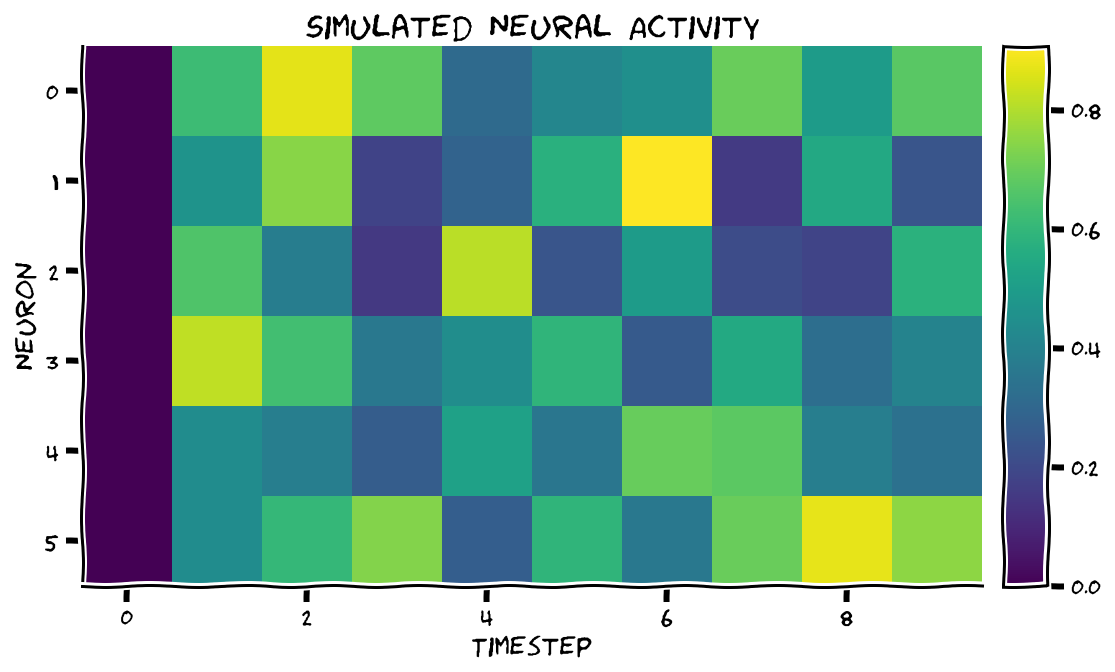

In [10]:
# to_remove solution
def simulate_neurons(A, timesteps, random_state=42):
    """Simulates a dynamical system for the specified number of neurons and timesteps.

    Args:
        A (np.array): the connectivity matrix
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): random seed for reproducibility
        
    Returns:
        - X has shape (n_neurons, timeteps). A schematic:
                   ___t____t+1___
       neuron  0  |   0    1     |
                  |   1    0     |
       neuron  i  |   0 -> 1     |
                  |   0    0     |
                  |___1____0_____|

    """
    np.random.seed(random_state)

    n_neurons = len(A)
    X = np.zeros((n_neurons, timesteps))

    for t in range(timesteps - 1):

        # Create noise vector
        epsilon = np.random.multivariate_normal(np.zeros(n_neurons), np.eye(n_neurons))

        # Update activity vector for next step
        X[:, t+1] = sigmoid(A @ X[:,t] + epsilon)  # we are using helper function sigmoid

    return X


# Set simulation length
timesteps = 5000

# Uncomment below to test your function

# Simulate our dynamical system
X = simulate_neurons(A, timesteps)

with plt.xkcd():
  plot_neural_activity(X)

---
# Section 3: Recovering connectivity through perturbation

Video available at https://youtu.be/wOZunGtuqQE


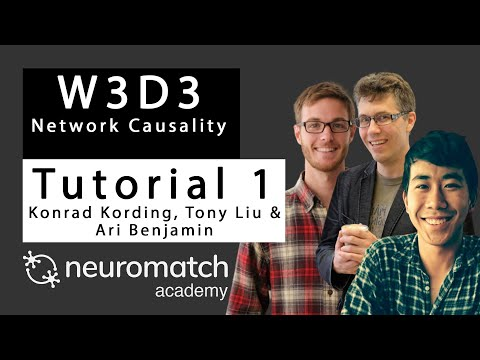

In [11]:
#@title Video 3: Perturbing systems
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="wOZunGtuqQE", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Section 3.1: Random perturbation in our system of neurons

We want to get the causal effect of each neuron upon each other neuron. The ground truth of the causal effects is the connectivity matrix $A$.

Remember that we would like to calculate:
$$
\delta_{A\to B} = \mathbb{E}[B | A=1] -  \mathbb{E}[B | A=0] 
$$


We'll do this by randomly setting the system state to 0 or 1 and observing the outcome after one timestep. If we do this $N$ times, the effect of neuron $i$ upon neuron $j$ is:
$$
\delta_{x^i\to x^j} \approx \frac1N \sum_i^N[x_{t+1}^j | x^i_t=1] -  \frac1N \sum_i^N[x_{t+1}^j | x^i_t=0]
$$
This is just the average difference of the activity of neuron $j$ in the two conditions.

We are going to calculate the above equation, but imagine it like *intervening* in activity every other timestep.

We will use helper function `simulate_neurons_perturb`. While the rest of the function is the same as the ``simulate_neurons`` function in the previous exercise, every time step we now additionally include:
```
if t % 2 == 0:
    X[:,t] = np.random.choice([0,1], size=n_neurons)
```

This means that at every other timestep,  every neuron's activity is changed to either 0 or 1. 

Pretty serious perturbation, huh? You don't want that going on in your brain.

**Now visually compare the dynamics:** Run this next cell and see if you can spot how the dynamics have changed.

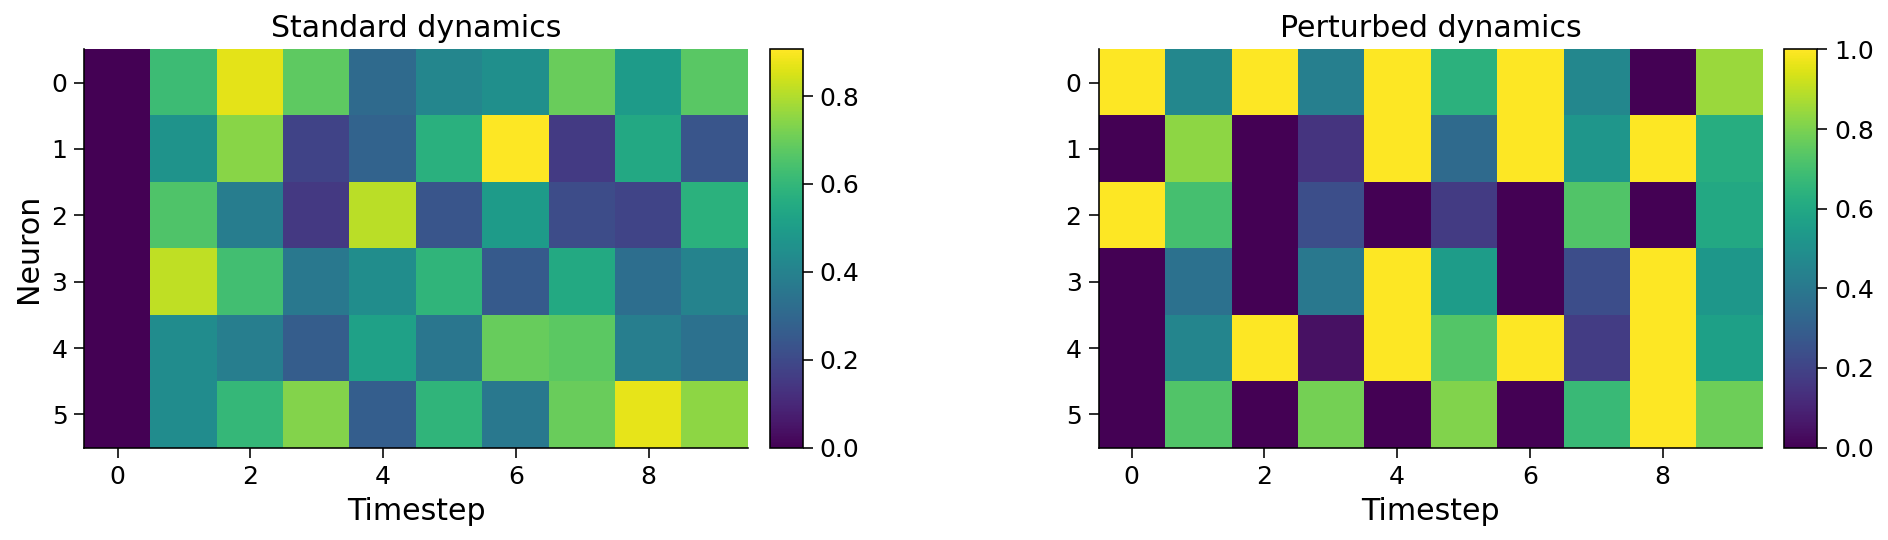

In [12]:
# @markdown Execute this cell to visualize perturbed dynamics

timesteps = 5000  # Simulate for 5000 timesteps.

# Simulate our dynamical system for the given amount of time
X_perturbed = simulate_neurons_perturb(A, timesteps)

# Plot our standard versus perturbed dynamics
fig, axs = plt.subplots(1, 2, figsize=(15, 4)) 
im0 = axs[0].imshow(X[:,:10])
im1 = axs[1].imshow(X_perturbed[:,:10])

# Matplotlib boilerplate code
divider = make_axes_locatable(axs[0])
cax0 = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im0, cax=cax0)

divider = make_axes_locatable(axs[1])
cax1 = divider.append_axes("right", size="5%", pad=0.15)
plt.colorbar(im1, cax=cax1)

axs[0].set_ylabel("Neuron", fontsize=15)
axs[1].set_xlabel("Timestep", fontsize=15)
axs[0].set_xlabel("Timestep", fontsize=15);
axs[0].set_title("Standard dynamics", fontsize=15)
axs[1].set_title("Perturbed dynamics", fontsize=15);

Video available at https://youtu.be/EDZtcsIAVGM


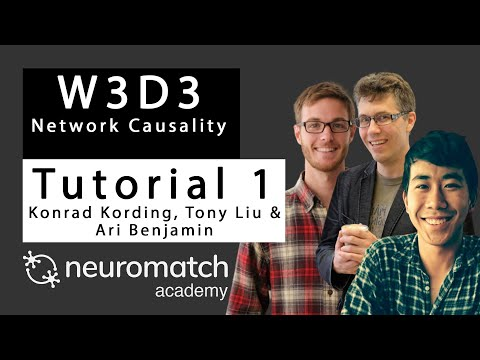

In [13]:
#@title Video 4: Calculating causality
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="EDZtcsIAVGM", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Exercise 3: Using perturbed dynamics to recover connectivity

From the above perturbed dynamics, write a function that recovers the causal effect of a given single neuron (`selected_neuron`) upon all other neurons in the system. Remember from above you're calculating:
$$
\delta_{x^i\to x^j} \approx \frac1N \sum_i^N[x_{t+1}^j | x^i_t=1] -  \frac1N \sum_i^N[x_{t+1}^j | x^i_t=0]] 
$$


Recall that we perturbed every neuron at every other timestep. Despite perturbing every neuron, in this exercise we are concentrating on computing the causal effect of a single neuron (we will look at all neurons effects on all neurons next). We want to exclusively use the timesteps without perturbation for $x^j_{t+1}$ and the timesteps with perturbation for $x^j_{t}$ in the formulas above. In numpy, indexing occurs as `array[ start_index : end_index : count_by]`. So getting every other element in an array (such as every other timestep) is as easy as `array[::2]`.

In [14]:
def get_perturbed_connectivity_from_single_neuron(perturbed_X, selected_neuron):
    """
    Computes the connectivity matrix from the selected neuron using differences in means.

    Args:
        perturbed_X (np.ndarray): the perturbed dynamical system matrix of shape (n_neurons, timesteps)
        selected_neuron (int): the index of the neuron we want to estimate connectivity for

    Returns:
        estimated_connectivity (np.ndarray): estimated connectivity for the selected neuron, of shape (n_neurons,)
    """
    # Extract the perturbations of neuron 1 (every other timestep)
    neuron_perturbations = perturbed_X[selected_neuron, ::2]
    
    # Extract the observed outcomes of all the neurons (every other timestep)
    all_neuron_output = perturbed_X[:, 1::2]

    # Initialize estimated connectivity matrix
    estimated_connectivity = np.zeros(n_neurons)

    # Loop over neurons
    for neuron_idx in range(n_neurons):

        # Get this output neurons (neuron_idx) activity
        this_neuron_output = all_neuron_output[neuron_idx, :]

        # Get timesteps where the selected neuron == 0 vs == 1
        one_idx = np.argwhere(neuron_perturbations == 1)
        zero_idx = np.argwhere(neuron_perturbations == 0)

        ########################################################################
        ## TODO: Insert your code here to compute the neuron activation from perturbations.
        # Fill out function and remove
        raise NotImplementedError("Complete the function get_perturbed_connectivity_single_neuron")
        ########################################################################
        
        difference_in_means = ...

        estimated_connectivity[neuron_idx] = difference_in_means

    return estimated_connectivity


# Initialize the system
n_neurons = 6
timesteps = 5000
selected_neuron = 1

# Simulate our perturbed dynamical system 
perturbed_X = simulate_neurons_perturb(A, timesteps)


## Uncomment below to test your function

# Measure connectivity of neuron 1
# estimated_connectivity = get_perturbed_connectivity_from_single_neuron(perturbed_X, selected_neuron)

# plot_true_vs_estimated_connectivity(estimated_connectivity, A, selected_neuron)

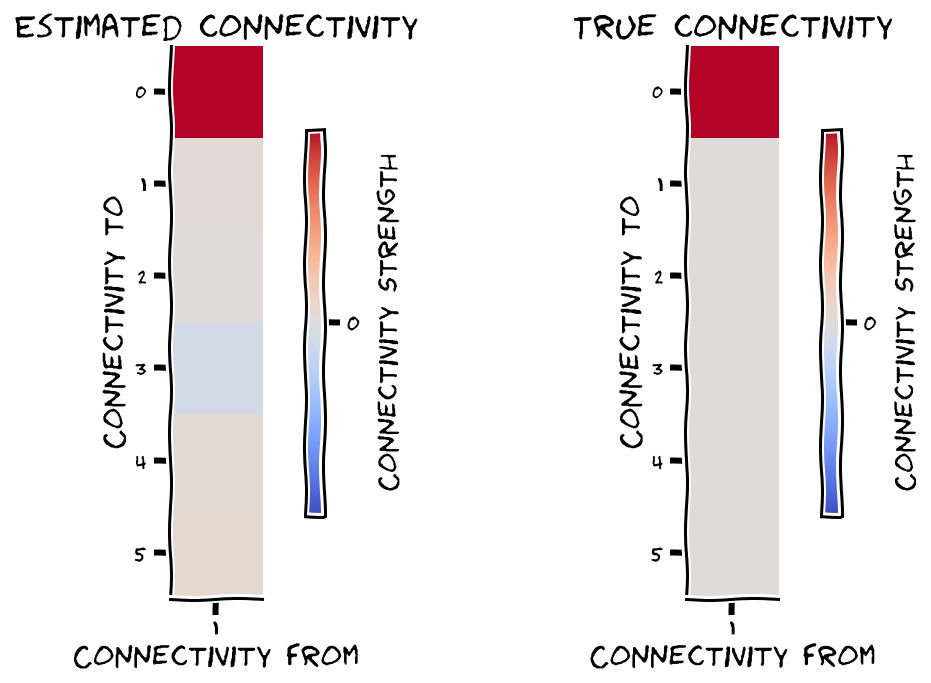

In [15]:
# to_remove solution
def get_perturbed_connectivity_from_single_neuron(perturbed_X, selected_neuron):
    """
    Computes the connectivity matrix from the selected neuron using differences in means.

    Args:
        perturbed_X (np.ndarray): the perturbed dynamical system matrix of shape (n_neurons, timesteps)
        selected_neuron (int): the index of the neuron we want to estimate connectivity for

    Returns:
        estimated_connectivity (np.ndarray): estimated connectivity for the selected neuron, of shape (n_neurons,)
    """
    # Extract the perturbations of neuron 1 (every other timestep)
    neuron_perturbations = perturbed_X[selected_neuron, ::2]
    
    # Extract the observed outcomes of all the neurons (every other timestep)
    all_neuron_output = perturbed_X[:, 1::2]

    # Initialize estimated connectivity matrix
    estimated_connectivity = np.zeros(n_neurons)

    # Loop over neurons
    for neuron_idx in range(n_neurons):

        # Get this output neurons (neuron_idx) activity
        this_neuron_output = all_neuron_output[neuron_idx, :]

        # Get timesteps where the selected neuron == 0 vs == 1
        one_idx = np.argwhere(neuron_perturbations == 1)
        zero_idx = np.argwhere(neuron_perturbations == 0)

        difference_in_means = np.mean(this_neuron_output[one_idx]) - np.mean(this_neuron_output[zero_idx])

        estimated_connectivity[neuron_idx] = difference_in_means

    return estimated_connectivity


# Initialize the system
n_neurons = 6
timesteps = 5000
selected_neuron = 1

# Simulate our perturbed dynamical system 
perturbed_X = simulate_neurons_perturb(A, timesteps)


## Uncomment below to test your function

# Measure connectivity of neuron 1
estimated_connectivity = get_perturbed_connectivity_from_single_neuron(perturbed_X, selected_neuron)

with plt.xkcd():
  plot_true_vs_estimated_connectivity(estimated_connectivity, A, selected_neuron)

We can quantify how close our estimated connectivity matrix is to our true connectivity matrix by correlating them. We should see almost perfect correlation between our estimates and the true connectivity - do we?

In [16]:
# Correlate true vs estimated connectivity matrix
np.corrcoef(A[:, selected_neuron], estimated_connectivity)[1, 0]

0.9923739307995421

## Section 3.2: Measuring how perturbations recover the entire connectivity matrix

Nice job! You just estimated connectivity for a single neuron.

We're now going to use the same strategy for all neurons at once. We provide this helper function `get_perturbed_connectivity_all_neurons`.  If you're curious about how this works and have extra time, scroll to the explanation at the bottom.


In [17]:
# Parameters
n_neurons = 6
timesteps = 5000

# Generate nxn causal connectivity matrix
A = create_connectivity(n_neurons)

# Simulate perturbed dynamical system 
perturbed_X = simulate_neurons_perturb(A, timesteps)

# Get estimated connectivity matrix
R = get_perturbed_connectivity_all_neurons(perturbed_X)

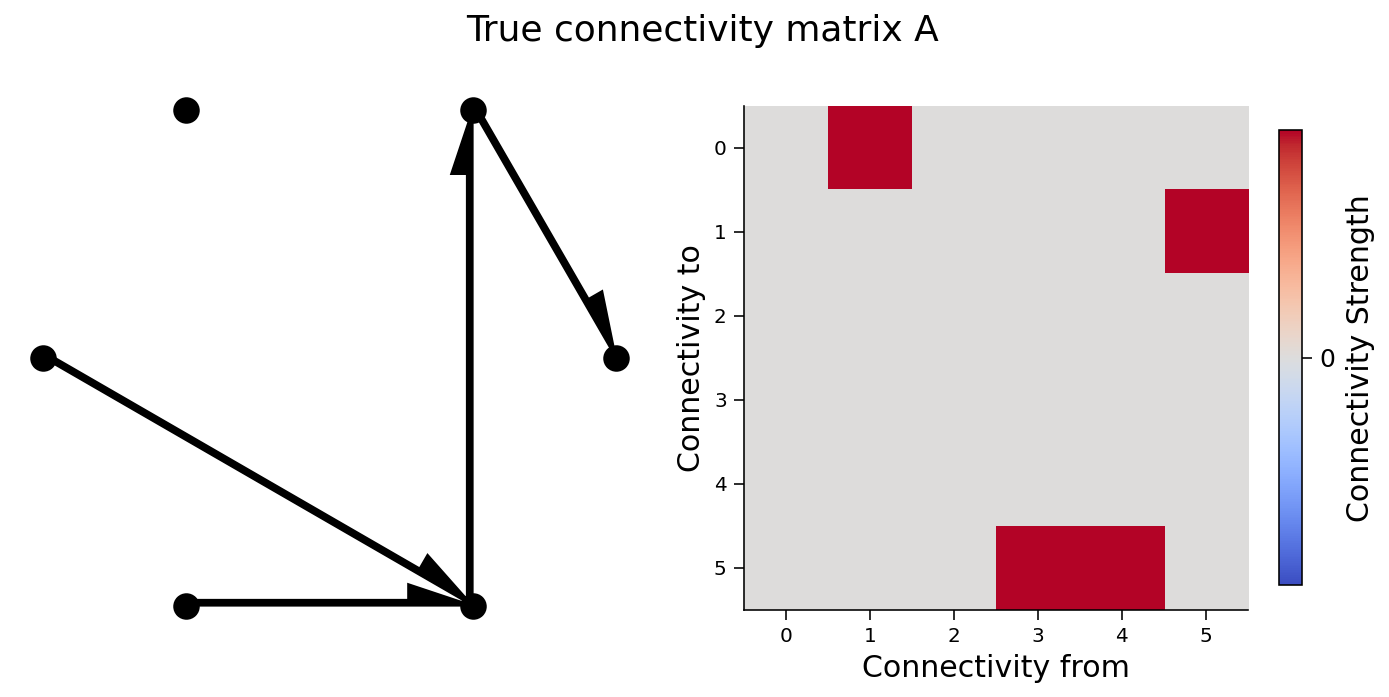

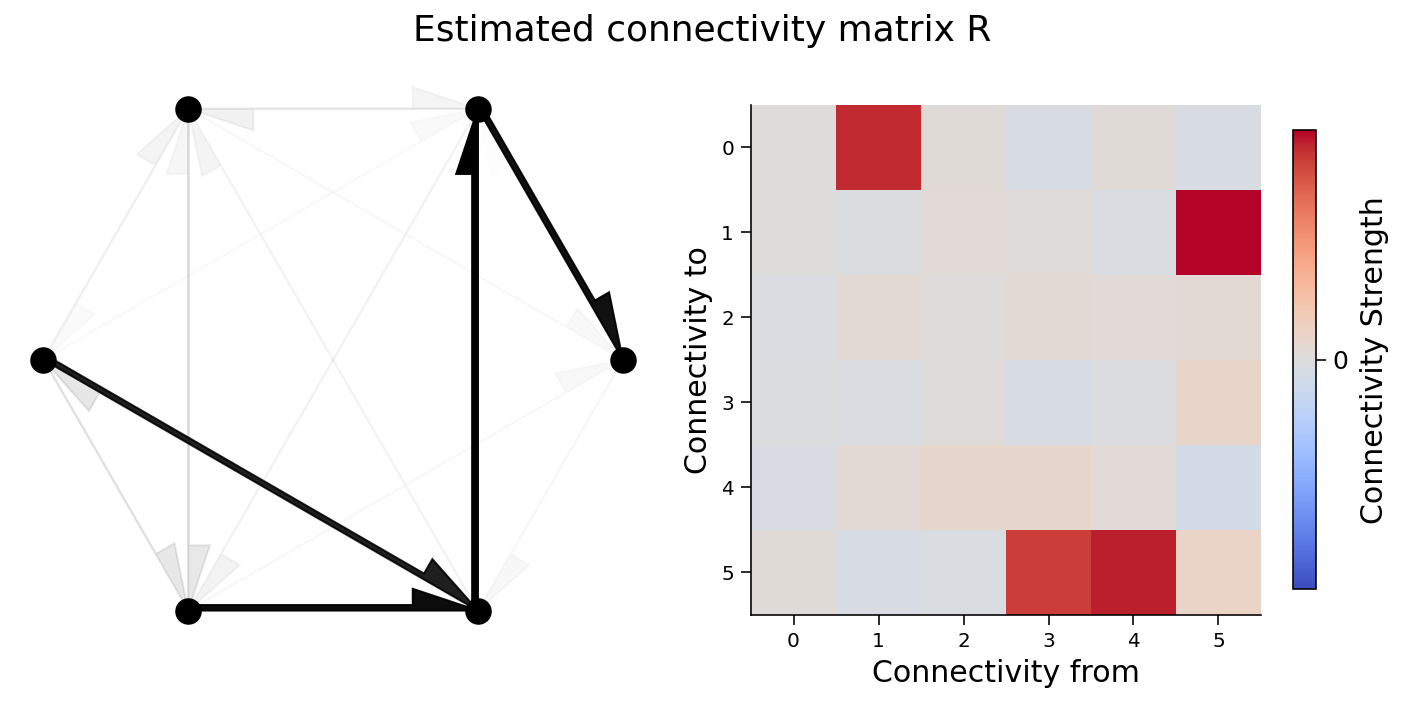

In [18]:
#@markdown Execute this cell to visualize true vs estimated connectivity

# Let's visualize the true connectivity and estimated connectivity together
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
see_neurons(A, axs[0]) # we are invoking a helper function that visualizes the connectivity matrix
plot_connectivity_matrix(A, ax=axs[1])
plt.suptitle("True connectivity matrix A");
plt.show()
fig, axs = plt.subplots(1,2, figsize=(10,5))
see_neurons(R.T,axs[0]) # we are invoking a helper function that visualizes the connectivity matrix
plot_connectivity_matrix(R.T, ax=axs[1])
plt.suptitle("Estimated connectivity matrix R");

We can again calculate the correlation coefficient between the elements of the two matrices. As you can see from the cell below, we do a good job recovering the true causality of the system!

In [19]:
np.corrcoef(A.transpose().flatten(), R.flatten())[1, 0]

0.987593404378358

---
# Summary

Video available at https://youtu.be/p3fZW5Woqa4


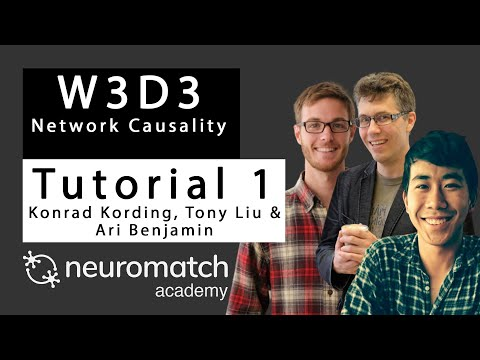

In [20]:
#@title Video 5: Summary
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="p3fZW5Woqa4", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

In this tutorial, we learned about how to define and estimate causality using pertubations. In particular we:

1) Learned how to simulate a system of connected neurons

2) Learned how to estimate the connectivity between neurons by directly perturbing neural activity

---
# Further resources for today

If you are interested in causality after NMA ends, here are some useful texts to consult.


*   *Causal Inference for Statistics, Social, and Biomedical Sciences* by Imbens and Rubin
*   *Causal Inference: What If* by Hernan and Rubin
*   *Mostly Harmless Econometrics* by Angrist and Pischke
*   https://www.nature.com/articles/s41562-018-0466-5 for application to neuroscience



---
# Appendix


## Computation of the estimated connectivity matrix

**This is an explanation of what the code is doing in `get_perturbed_connectivity_all_neurons()`**

First, we compute an estimated connectivity matrix $R$. We extract
perturbation matrix $P$ and outcomes matrix $O$:

$$
P = \begin{bmatrix}
\mid & \mid & ... & \mid \\ 
x_0  & x_2  & ... & x_T  \\ 
\mid & \mid & ... & \mid
\end{bmatrix}_{n \times T/2}
$$

$$
O = \begin{bmatrix}
\mid & \mid & ... & \mid \\ 
x_1  & x_3  & ... & x_{T-1}  \\ 
\mid & \mid & ... & \mid
\end{bmatrix}_{n \times T/2}
$$

And calculate the correlation of matrix $S$, which is $P$ and $O$ stacked on each other:

$$
S = \begin{bmatrix}
P  \\ 
O
\end{bmatrix}_{2n \times T/2}
$$

We then extract $R$ as the upper right $n \times n$ block of $corr(S)$:


This is because the upper right block corresponds to the estimated perturbation effect on outcomes for each pair of neurons in our system.